# Lecture 1: Why and how to build a model

## Lecture overview

1. [Why to build a model](#section1)
2. [How to build a model](#section2)
3. [Summary](#section3)

<span id='section1'></span>
## 1. Why to build a model
<hr>

Mathematics permeates ecology and evolution, from simple back-of-the-envelope calculations to the development of sophisticated mathematical models. This is because mathematics is a unique tool that can take what we already know (or assume to be true) and rigorously lead us to the logical conclusions.

To see this (while also introducing you to the kind of models I work with), let's look at an example. See sections 1.2-1.4 of the text for another motivating example (within-patient HIV dynamics).

### Motivating model: evolution during extreme events

This is a model that I helped Dr. Kelsey Lyberger (then a PhD student at UC Davis) with in our paper, [Lyberger et al 2021](https://www.biorxiv.org/content/10.1101/2020.04.02.014951v2).

<center>

<img alt="kelsey" src="../lecture-01-img/kelsey.png" width=50%>

</center>

<center><sup>Kelsey Lyberger, doing <i>Daphnia</i> fieldwork I suppose.</sup></center>

Kelsey was interested in how populations respond to extreme climatic events, like lizards to hurricanes. It has long been clear that such events can impact the size of a population, e.g., by causing extra mortality, and may in fact put populations at risk of extinction. More recently it has become apparent that extreme events can also impose strong natural selection, and that populations can quickly adapt to the new environment. Some examples include:

- [Hurricanes select on lizard limbs and toe pads](https://www.pnas.org/doi/10.1073/pnas.2000801117)
- [Ice-storms select on sparrow body size](https://www.jstor.org/stable/2406980)
- [Droughts select on Darwin finch beaks](https://www.science.org/doi/10.1126/science.aad8786)
- [Droughts select on flowering time in *Brassica*](https://nph.onlinelibrary.wiley.com/doi/10.1111/j.1469-8137.2010.03603.x)

<center>
<img alt="lizards" src="../lecture-01-img/lizard.png">
</center>

<center><sup>Lizard being blown off perch by a leaf blower. Source: colindonihue.com</sup></center>

Now, how should such rapid adaptive evolution impact population size? This is the question Kelsey set out to answer with a mathematical model.

??? note "Details of Kelsey's model"

    Kelsey assumed each individual has a quantitative genetic trait, such as lizard limb length, that is determined by many alleles of small effect plus some environmental noise. Fitness is assumed to be a bell-shaped function of the difference between the optimum trait value, $\theta$, and an individual's trait value, $z$, which we write as $W(\theta - z)$. 
    
    The change in population size, $N$, from one generation to rate the next is the current population size times mean fitness, $\overline{W}(\theta - \bar{z})$, the latter depending on the population mean trait value, $\bar{z}$. This gives

    $\Delta N = N \overline{W}(\theta - \bar{z}).$
    
    The change in the mean trait value from one generation to the next is roughly the product of genetic variance in the trait, $V_g$, and the strength of selection. The strength of selection is defined as the derivative of the natural logarithm of population mean fitness with respect to the mean trait value, $\mathrm{d}\ln\overline{W}(\theta - \bar{z})/\mathrm{d}\bar{z}$. This gives
    
    $\Delta \bar{z} = V_g \frac{\mathrm{d}}{\mathrm{d}\bar{z}}\ln\overline{W}(\theta - \bar{z}).$
    
    Together, these coupled recursion equations, $\Delta N$ and $\Delta \bar{z}$, can be used to describe how evolution affects population size under an extreme event, which is modeled as a sudden but temporary change in the optimum phenotype, $\theta$.

Below we numerically iterate the two equations above (dashed lines) and compare with stochastic simulations (solid lines) to recreate Figure 1 from Lyberger et al. With an activated kernel, you can tinker and run the code below to adjust the plot (the simulations take a few seconds). 

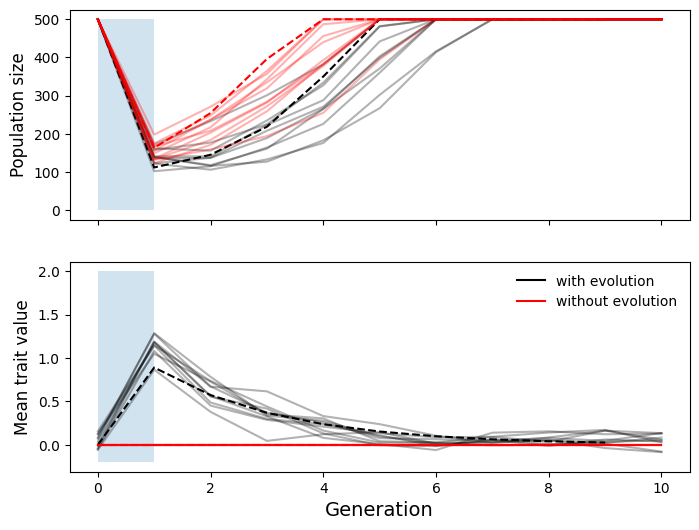

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# choose parameter values
Vo, Ve, event_duration, seed = 0.75, 0, 1, 0
generations, K, w, lmbda, event_time, initial_theta_t, dtheta_t, event_duration = 110, 500, 1, 2, 100, 0, 2.5, 1
nreps = 10

# simulation
def lyberger_model(Vo, Ve, event_duration, seed, generations, K, w, lmbda, event_time, initial_theta_t, dtheta_t):
    
    # initialize population
    members = np.random.normal(initial_theta_t, Vo**0.5, K) #K individuals with trait values distributed around the optimum
    
    # run simulations
    np.random.seed(seed)
    population_size, mean_breeding_value = [], []
    for g in range(generations):

        # optimum trait value
        if g in np.arange(event_time, event_time + event_duration):
            theta_t = initial_theta_t + dtheta_t #extreme event
        else:
            theta_t = initial_theta_t #normal

        # viability selection
        prob_survival = np.array([np.exp(-(theta_t - z + np.random.normal(0, Ve))**2 / (2*w**2)) for z in members])
        survived = np.array([True if p > np.random.uniform(0,1) else False for p in prob_survival])
        if len(survived) == 0:
            break
        members = members[survived]

        # random mating
        offspring = []
        for m in np.random.choice(members, len(members)):
            if len(offspring) > K: #if more than K offspring already then choose K and stop matings
                offspring = np.random.choice(offspring, K)
                break
            else:
                n_off = np.random.poisson(lmbda)
                mate = np.random.choice(members)
                offspring += [(m + mate)/2 for _ in range(n_off)] #give offspring mean parental value

        # sample new trait values for offspring
        offspring = np.array(offspring)
        offspring = np.random.normal(offspring, Vo) #add segregation variance

        # record statistics
        population_size.append(len(offspring))
        mean_breeding_value.append(np.mean(offspring))

        # update for next generation
        members = offspring
    
    return (
        np.arange(0, generations-event_time+1), #times
        np.array(population_size[event_time-1:]), #population size
        np.array(mean_breeding_value[event_time-1:]) #mean trait value
    )

# recursions
def recursions(t0,n0,z0,lmbda,w,K,event_time,event_duration,initial_theta_t,dtheta_t,Vo,Ve,tmax=np.inf):
    
    # initialize
    t,nt,zt=t0,n0,z0

    Vs = w**2 + Ve
    Vg = (2*Vo - Vs + np.sqrt(4*Vo**2 + 12*Vo*Vs + Vs**2))/4
    Vt = Vg + Vs

    # yield and update
    while t<tmax:
        yield t, nt, zt
        if t in np.arange(event_time, event_time + event_duration):
            theta_t = initial_theta_t + dtheta_t #extreme event
        else:
            theta_t = initial_theta_t #normal
        t += 1
        nt = min(nt*lmbda*np.exp(-( (theta_t - zt)**2 + Vg + Ve)/ (2*Vt)), K)
        zt += Vg*(theta_t - zt) / Vt

# initialize plot
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(8,6)

# run 10 simulations per segregation (Vo) and environment variance (Ve) parameter combination
for Vo, Ve, c, lab in [[0.75, 0, 'black', 'with evolution'], [0, 1, 'red', 'without evolution']]:

    # plot simulations
    simulations = np.array([lyberger_model(Vo, Ve, event_duration, s, generations, K, w, lmbda, event_time, initial_theta_t, dtheta_t) for s in range(nreps)])
    ax[0].plot(simulations[:,0].T, simulations[:,1].T, color=c, alpha=0.3);
    ax[1].plot(simulations[:,0].T, simulations[:,2].T, color=c, alpha=0.3);

    # plot recursions
    tnz = recursions(0,K,initial_theta_t,lmbda,w,K,event_time,event_duration,initial_theta_t,dtheta_t,Vo/2,Ve,generations)
    tnzs = np.array([vals for vals in tnz])
    ax[0].plot(tnzs[event_time:,0]-event_time,tnzs[event_time:,1], color=c, linestyle='--')
    ax[1].plot(tnzs[event_time:,0]-event_time,tnzs[event_time:,2], color=c, linestyle='--')
    
    # hack together only one instance of the legend
    ax[0].plot([np.min(simulations[:,0].T)], [np.min(simulations[:,1].T)], alpha=1,
                  label = lab, color=c)
    ax[1].plot([np.min(simulations[:,0].T)], [np.min(simulations[:,2].T)], alpha=1,
                  label = lab, color=c)

# add environmental event duration
ax[0].fill_between([0,event_duration], y1=K, alpha=0.2)
ax[1].fill_between([0,event_duration], y1=-0.2, y2=2, alpha=0.2)

# add labels
ax[0].set_ylabel('Population size', fontsize=12)
ax[1].set_ylabel('Mean trait value', fontsize=12)
ax[1].set_xlabel('Generation', fontsize=14)

# add legend
plt.legend(frameon=False)
plt.show()

The key result, that you can see in the plot above, is that when extreme events are short, adaptive evolution (black lines) can paradoxically *reduce* population size (relative to the red lines, where there is no evolution). The reason for this is that, while during the extreme event (shaded section) evolution is adaptive, once the extreme event ends the population finds itself maladapted to the original environment. Adaptive evolution can therefore hamper population persistence, and this is an important thing to keep in mind when documenting rapid adaptive evolution in response to extreme events -- it is not necessarily a good thing for the species (or our conservation goals).

<span id='section2'></span>
## 2. How to build a model
<hr>

Although many problems require specific formulations and assumptions, there are a few general principles to constructing a model.

### i. Formulate the question

- What do you want to know?
- Describe the model in the form of a question.
- Simplify, Simplify!
- Start with the simplest, biologically reasonable description of the problem.

For example, we might ask: how does immigration affect population size?

### ii. Determine the basic ingredients

- Define the **variables** in the model.
- Describe any constraints on the variables.
- Describe any interactions between variables.
- Decide whether you will treat time as continuous or discrete.
- Choose a time scale (i.e., decide what a time step equals in discrete time and specify whether rates will be measured per second, minute, day, year, generation, etc.).
- Define the **parameters** in the model.
- Describe any constraints on the parameters.

In our example, there is a single variable, $n(t)$, denoting population size at time $t$. This must be non-negative, $n(t)\geq0$, to be biologically valid. 

We'll look at both continuous and discrete time, with an arbitrary time scale (if we wanted to plug in some numerical parameter values we'd have to specify this, but here we won't).

In continuous time our parameters will be immigration rate ($m$), per capita birth rate ($b$), and per capita death rate ($d$). These must all be non-negative under our interpretation. The units of $m$ are individuals/time while the units of $b$ and $d$ are simply 1/time (e.g., for birth we have the number of individuals produced per individual per time, so that individuals cancels out and we are left with 1/time).

In discrete time the parameters will be the average number of immigrants per time step ($M$), the average number of offspring per individual per time step ($B$), and the fraction of individuals that die each time step ($D$). These must all be non-negative and $D$ must also be less than or equal to 1 as it is a fraction. 

### iii. Qualitatively describe the biological system

- For continuous-time models, draw a **flow diagram** to describe changes to the variables over time.
- For discrete-time models, draw a **life-cycle diagram** with all the events that occur each time unit.
- For discrete time models with multiple variables and events, construct a table listing the outcome of every event.
  
For our continuous-time example we could draw the following:
    
<center>
```mermaid
graph LR;
    A((n)) --birth--> A;
    B[ ] --migration--> A;
    A --death--> C[ ];
    style B height:0px;
    style C height:0px;
```   
</center>

For our discrete-time example, if we assume migration, then birth, then death each time step, we could draw the following:

<center>
```mermaid
graph LR;
    A((n)) --migration--> B((n'));
    B --birth--> C((n''));
    C --death--> A;
```   
</center>

We'll see an example of a table of events later in the course.

### iv. Quantitatively describe the biological system

- Using the diagrams and tables as a guide, write down the equations. Perform checks. Are the constraints on the variables still met as time passes? Make sure that the units of the right-hand side equal those on the left-hand side.
- For continuous-time models, add rates for arrows coming in to the flow diagram and subtract rates for arrows coming out of the flow diagram. 

For example, in the model shown above the rate of change in the number of individuals, $\frac{\mathrm{d} n}{\mathrm{d} t}$, is

$$
\begin{aligned}
\frac{\mathrm{d} n}{\mathrm{d} t} &= m + b n(t) - d n(t)\\
&= m + (b - d) n(t)
\end{aligned}
$$

This is a **differential equation**.

In discrete time, you must take into account the order of events when constructing equations. To build an equation for the population size in the next generation, $n(t+1)$, based on the life-cycle diagram above, first construct an equation for each event 

$$n' = n(t) + M$$

$$n'' = n' + Bn'$$

$$n(t+1) = n'' - Dn''$$

Next, substitute $n''$ and then $n'$ into the equation for $n(t+1)$ to write $n(t+1)$ in terms of $n(t)$

$$
\begin{aligned}
n(t+1) &= n'' − Dn'' \\
&= (n' + Bn') − D(n' + Bn') \\
&= n'(1 + B − D − DB) \\
&= (n(t) + M)(1 + B − D − DB) \\
\end{aligned}
$$

We now have a **recursion equation** that correctly takes into account the order of the life cycle (migration, birth, death) and the point at which the census is taken (immediately after death).

### v. Analyze the equations

- Start by using the equations to simulate and graph the changes to the system over time. 
- Choose and perform appropriate analyses.
- Make sure that the analyses can address the problem.

We'll save the mathematical analyses for later in the course, but let's try simulating the recursion equations here to get a sense of the dynamics (we'll learn more about how to do this in the next lecture).

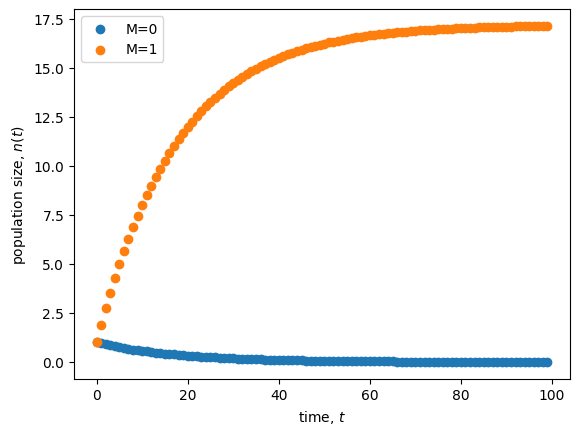

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# define a genarator to efficiently run the recursion
def recursion(n0, b, d, m, tmax):
    t,n=0,n0 #initial conditions
    while t<tmax:
        yield t,n #output current state
        t += 1 #update time
        n = (n + m) * (1 + b - d - b*d) #update population size using the recursion equation we derived above

# simulate and plot
fig, ax = plt.subplots()

n0, b, d, tmax, dt = 1, 0.05, 0.1, 100, 0.1 #parameter values
for m in [0,1]:
    tn = recursion(n0, b, d, m, tmax) #define recursion
    tns = np.array([vals for vals in tn]) #get output
    ax.scatter(tns[:,0], tns[:,1], label='M=%s'%m) #plot population size at each time
    
ax.set_xlabel('time, $t$')
ax.set_ylabel('population size, $n(t)$')
plt.legend()
plt.show()

How does migration affect population size?

### vi. Checks and balances

- Check the results against data or any known special cases.
- Determine how general the results are.
- Consider alternatives to the simplest model.
- Extend or simplify the model, as appropriate, and repeat steps 2-5.

If $b>d$ (or $B>D$) the population grows without bound (try this in the code above). But competition should prevent unbounded population growth. We could therefore extend the model to include competition.

### vii. Relate the results back to the question

- Do the results answer the biological question?
- Are the results counter-intuitive? Why?
- Interpret the results verbally, and describe conceptually any new insights into the biological process.
- Describe potential experiments.

Immigration appears to increase the population size (compare $M=0$ and $M=1$ in the plot above), though we'd need to do the mathematical analysis to be more confident in this statement. 

There is some counter-intuitiveness in the discrete model: try creating the recursion equation for a different order of events in the lifecycle. The recursion equation depends on the order and will therefore lead to different dynamics.

Potential experiments incude manipulating immigration in lab populations (e.g., bacteria) or comparing population sizes on islands that are different distances from the mainland.

<span id='section3'></span>
## 3. Summary
<hr>

- Mathematical models take us from assumptions to conclusions
- There is a recipe to build them